In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
! jupyter nbextension enable --py widgetsnbextension
np.set_printoptions(suppress=True)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<h1>Section 0/1 - Data Exploration/Building Probability Distributions</h1>

Just looking at the data and seeing what's doing on. Here is some stuff I found about the csv files.

<h4>atbats.csv</h4>

- <code>pitcher_id</code>: This has the pitcher id. In the player_names.csv, this is the <code>id</code> column.
- <code>batter_id</code>: This has the batter id. In the player_names.csv, this is the <code>id</code> column.
- <code>ab_id</code>: This is the id of the at bat. In the pitches.csv, this is the <code>ab_id</code> column.
- <code>g_id</code>: This is the id of the game.

<h4>Read in the data</h4>

In [3]:
# Read in data
pitches = pd.read_csv('csv_data/pitches.csv')
names = pd.read_csv('csv_data/player_names.csv')
at_bat = pd.read_csv('csv_data/atbats.csv')
games = pd.read_csv('csv_data/games.csv')

# Read in more recent data.
pitches_2019 = pd.read_csv('csv_data/2019_pitches.csv')
atbats_2019 = pd.read_csv('csv_data/2019_atbats.csv')
games_2019 = pd.read_csv('csv_data/2019_games.csv')

# Drop necessary columns to be able to stack data.
games.drop(columns=['delay'], inplace=True)

# Stack dataframes together.
print(f'pitches.shape {pitches.shape}, at_bat.shape {at_bat.shape}, games.shape {games.shape}')
pitches = pd.concat([pitches, pitches_2019], ignore_index=True, axis=0)
at_bat = pd.concat([at_bat, atbats_2019], ignore_index=True, axis=0)
games = pd.concat([games, games_2019], ignore_index=True, axis=0)
print(f'pitches.shape {pitches.shape}, at_bat.shape {at_bat.shape}, games.shape {games.shape}')

# Create column in names with full name.
names['full_name'] = names['first_name'] + ' ' + names['last_name']

pitches.shape (2867154, 40), at_bat.shape (740389, 11), games.shape (9718, 16)
pitches.shape (3595944, 40), at_bat.shape (925634, 11), games.shape (12126, 16)


<h4>Merge the data to get pitcher_id/full_name linked up with the pitches they threw</h4>

In [4]:
# Merge pitches and at_bats together.
pitches_merge = pitches.merge(at_bat, on='ab_id', validate='m:1')

# Merge pitches_merge and names together
pitches_merge = pitches_merge.merge(names, left_on='pitcher_id', right_on='id')
pitches_merge.drop(['last_name', 'first_name'], axis=1, inplace=True)
# pitches_merge.set_index('pitcher_id', inplace=True)
pitches_merge.head(5)

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,id,full_name
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,201500001.0,1.0,1,0.0,L,452657,L,True,452657,Jon Lester
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,201500001.0,1.0,1,0.0,L,452657,L,True,452657,Jon Lester
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,201500001.0,1.0,1,0.0,L,452657,L,True,452657,Jon Lester
3,-0.641,1.221,91.0,84.0,1289.59,169.751,-1.3,5.0,23.8,2.104,...,201500001.0,1.0,1,0.0,L,452657,L,True,452657,Jon Lester
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,201500001.0,1.0,1,0.0,L,452657,L,True,452657,Jon Lester


<h4>Save <code>pitches_merge</code> as parquet file (for ease of reloading)</h4>

In [6]:
# The column spin_rate has value 'placeholder' for 641k rows. Convert those all to 0.
pitches_merge['spin_rate'] = pitches_merge.spin_rate.replace('placeholder', 0)
pitches_merge['spin_dir'] = pitches_merge.spin_dir.replace('placeholder', 0)
pitches_merge['type_confidence'] = pitches_merge.type_confidence.replace('placeholder', 0)
pitches_merge['zone'] = pitches_merge.zone.replace('placeholder', 0)
pitches_merge['x'] = pd.to_numeric(pitches_merge['x'], errors='coerce')
pitches_merge['y'] = pd.to_numeric(pitches_merge['y'], errors='coerce')
pitches_merge['code'] = pitches_merge.code.astype(str)
pitches_merge['type'] = pitches_merge.type.astype(str)
pitches_merge['top'] = pitches_merge.top.replace({1.0: True, 0.0: False})

# Convert to parquet.
pitches_merge.to_parquet('pitches_data.parquet')

<h4>Create json file of pitchers full_name and their pitch distribution</h4>

In [7]:
# Get all possible unique pitchers
all_pitchers = pitches_merge.full_name.unique().tolist()

# Create variables
pitch_distributions = dict()

# Iterate through all unique pitchers, getting their distribution of pitches (set up like json). Will look like this:
# {'name': 
#         {'pitch_keys': [keys corresponding to pitches],
#          'pitch_dist' : [distribution of pitches (same order as keys)]}
# }
# Iterate through all pitchers
for pitcher in all_pitchers:
    # Get a pitcher subset
    subset = pitches_merge.loc[pitches_merge.full_name == pitcher]

    # Get the distribution
    dist = subset['pitch_type'].value_counts() / np.sum(subset['pitch_type'].value_counts())

    # Create the inner dictionary (pitch_keys and pitch_dist) and add it to main dictionary with the key as the pitchers name.
    pitch_distributions[pitcher] = {'pitch_keys': dist.index.tolist(), 'pitch_dist' : dist.values.tolist()}

<h4>(View <code>pitch_distributions</code> as a json file)</h4>

(and save it as a json file)

In [8]:
# j = json.load([pitch_distributions])
j = json.dumps(pitch_distributions, indent=4)[:403]

with open("pitcher_distribution.json", "w") as outfile:
    json.dump(pitch_distributions, outfile)
print(j)

{
    "Jon Lester": {
        "pitch_keys": [
            "FF",
            "FC",
            "CU",
            "SI",
            "CH",
            "PO"
        ],
        "pitch_dist": [
            0.41672005124919925,
            0.2591287636130685,
            0.14433055733504163,
            0.10147341447789879,
            0.07815502882767457,
            0.00019218449711723255
        ]
    },


<h4>Figuring out how to randomly select from distributions</h4>

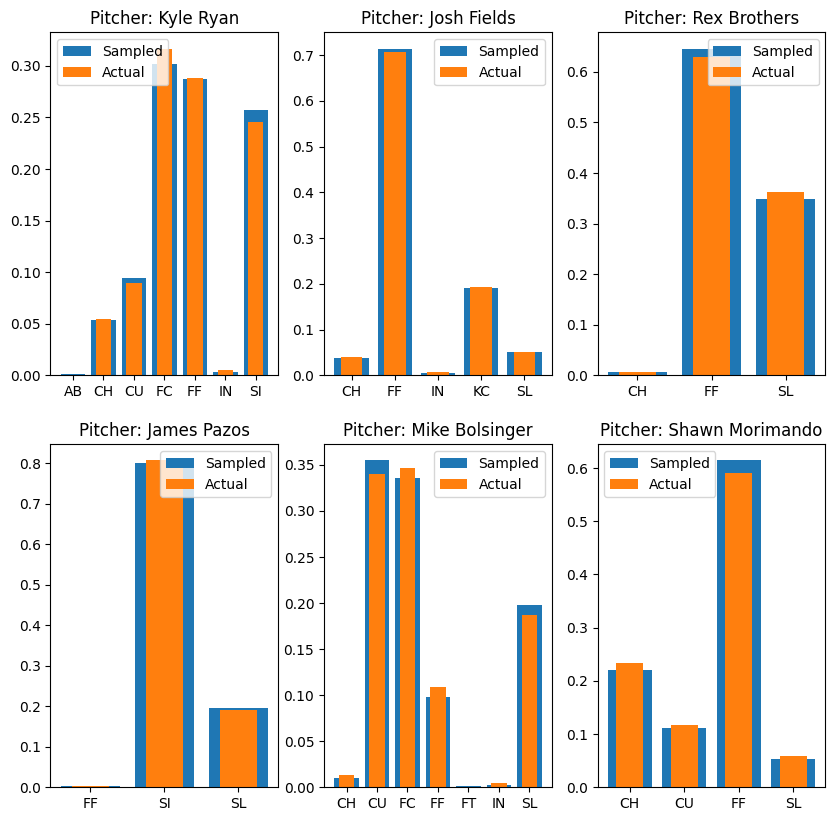

In [9]:
list_of_pitchers = list(pitch_distributions.keys())

# Initilize subplots for better viewing.
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(10,10), dpi=100)
r, c = 0, 0
for i in range(rows*cols):
    # Randomly select a pitcher
    randomly_selected_pitcher = np.random.choice(list_of_pitchers)

    # Get that pitchers distribution.
    randomly_selected_pitch = np.random.choice(pitch_distributions[randomly_selected_pitcher]['pitch_keys'], 
                                            p=pitch_distributions[randomly_selected_pitcher]['pitch_dist'],
                                            size=2500)

    # To ensure that things are working the way they are supposed to, randomly sample pitch types a ton and make sure the law
    # of large numbers kicks in.
    vals, counts = np.unique(randomly_selected_pitch, return_counts=True)
    ax[r, c].bar(vals, counts/np.sum(counts), label='Sampled')
    ax[r, c].bar(pitch_distributions[randomly_selected_pitcher]['pitch_keys'],
            pitch_distributions[randomly_selected_pitcher]['pitch_dist'],
            width=0.5, label='Actual')
    ax[r,c].legend()
    ax[r,c].set_title(f'Pitcher: {randomly_selected_pitcher}')

    c += 1
    if c == cols:
        r += 1
        c = 0

plt.show()


<h1>Section 2 - CatBoost Baseline</h1>

The first thing we need to do is figure out what data will be the most helpful when determining what pitch might come next. This should be stuff that the hitter has access to, so things like outs, on_1b, etc, but not stuff like spin rate. (The <code>pitches_merge</code> dataframe has just about everything.) Here is a list of potentially important features:

- FROM pitches.csv
    - b_score: This is the score for the batters team.
    - b_count: Number of balls in the at bat.
    - s_count: Number of strikes in the at bat.
    - outs: Number of outs in the inning.
    - pitch_num: Number of pitches in the at bat.
    - on_1b: Whether or not there is a runner on first base.
    - on_2b: Whether or not there is a runner on second base.
    - on_3b: Whether or not there is a runner on third base.
- FROM atbats.csv
    - batter_id: The id of the batter.
    - event: This is what the result of the previous at bat was (single, groundout, strikeout, etc). It could be good to know the result of the previous at bat.
    - inning: What inning the at bat is in.
    - outs: Number of outs in the inning AFTER the current at bat.
    - p_score: This is the score for the pitchers team.
    - p_throws: Whether the pitcher throws left or right handed.
    - stand: Whether the batter bats left or right handed.
        - These two could have a pretty strong correlation with pitch type?
    - top: Whether the team is the home team or not.
- FROM games.csv
    - wind: The wind in mph and the direction (may be useful?).
    - weather: The weather at the game (may be useful?).


In [10]:
# Create a list of columns to keep before merging everything together.
columns_to_keep = ['b_score', 'b_count', 's_count', 'current_outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b',
                   'batter_id', 'inning', 'p_score', 'p_throws', 'stand', 'top',
                   'wind', 'weather', 'pitch_type']

# Merge pitches and atbats
pitches.rename(columns={'outs': 'current_outs'}, inplace=True)
catboost_df = pitches.merge(at_bat, on='ab_id', validate='m:1')
print(f'catboost_df.shape: {catboost_df.shape}')

# Merge catboost_df and games
catboost_df = catboost_df.merge(games, on='g_id')
print(f'catboost_df.shape: {catboost_df.shape}')

# Keep only the columns I want to plug into catboost
catboost_df = catboost_df[columns_to_keep]
print(f'catboost_df.shape: {catboost_df.shape}')

# Rename a few columns
catboost_df.rename(columns={'stand': 'batter_stance'}, inplace=True)

# These columns are objects that are actually int64's. Convert to string to run in the algorithm.
catboost_df[['p_throws', 'batter_stance', 'wind', 'weather']] = catboost_df[['p_throws', 'batter_stance', 'wind', 'weather']].astype('string')
catboost_df[['p_throws', 'batter_stance']] = catboost_df[['p_throws', 'batter_stance']].replace({'R': 'Right', 'L': 'Left'})


catboost_df.head(5)

catboost_df.shape: (3595944, 50)
catboost_df.shape: (3595944, 65)
catboost_df.shape: (3595944, 17)


,b_score,b_count,s_count,current_outs,pitch_num,on_1b,on_2b,on_3b,batter_id,inning,p_score,p_throws,batter_stance,top,wind,weather,pitch_type
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,"7 mph, In from CF","44 degrees, clear",FF
1,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,"7 mph, In from CF","44 degrees, clear",FF
2,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,"7 mph, In from CF","44 degrees, clear",FF
3,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,"7 mph, In from CF","44 degrees, clear",FF
4,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,"7 mph, In from CF","44 degrees, clear",CU


In [11]:
## This may be something we might want to include next time.
X = catboost_df.iloc[:, :-1]
y = catboost_df.iloc[:, -1]
print(f'X.shape, y.shape : {X.shape}, {y.shape}')

X.shape, y.shape : (3595944, 16), (3595944,)


In [13]:
# Split our data
X_train, X_val, y_train, y_val = train_test_split(
	X, y, test_size=0.25, random_state=28)

# Define the hyperparameters for the CatBoost algorithm
params = {'learning_rate': 0.1, 'depth': 6,\
		'l2_leaf_reg': 3, 'iterations': 25}

# Get indicies where column data types are not floats.
categorical_features_indices = np.where(X.dtypes != np.float)[0]

# Initialize the CatBoostClassifier object
# with the defined hyperparameters and fit it on the training set
model = CatBoostClassifier(**params)
model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_val, y_val), save_snapshot=True, 
          snapshot_file='catboost_snapshot/', snapshot_interval=6, verbose=True)


<ipython-input-13-1d91587a9d1d>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X.dtypes != np.float)[0]


AttributeError: 'DataFrame' object has no attribute 'iteritems'

In [ ]:
prediction = model.predict(X_val)

In [74]:
catboost_df.pitch_type_shift.value_counts(normalize=True)

FF    0.355727
SL    0.157933
FT    0.118467
CH    0.102626
SI    0.085001
CU    0.082157
FC    0.052491
KC    0.023303
FS    0.015319
KN    0.003947
IN    0.002172
EP    0.000286
FO    0.000284
PO     0.00022
SC     0.00004
UN     0.00002
FA    0.000003
AB    0.000003
Name: pitch_type_shift, dtype: Float64

: 

# Model 2 Baseline:

Model that randomly pulls from a pitchers pitch distribution to predict the pitch that will be thrown

This will be used as a baseline to compare the accuracy of our future model

In [13]:
#read in the pitches_merge from parquet
pitches_merge = pd.read_parquet('pitches_data.parquet')
pitches_merge.rename(columns={'outs': 'current_outs'}, inplace=True)
pitches_merge.columns

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'current_outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'batter_id', 'event', 'g_id',
       'inning', 'o', 'p_score', 'p_throws', 'pitcher_id', 'stand', 'top',
       'id', 'full_name'],
      dtype='object')

In [58]:
# For this model, all that we need is the pitch_type to be our truth value, 
# and the full name of the pitcher so we can sample from his distribution
columns_to_keep = ['full_name', 'pitch_type']
random_df = pitches_merge[columns_to_keep]
print(random_df.head(5))
print(random_df.shape)

    full_name pitch_type
0  Jon Lester         FF
1  Jon Lester         FF
2  Jon Lester         FF
3  Jon Lester         FF
4  Jon Lester         CU
(3514339, 2)


In [35]:
#load in the json file
with open('pitcher_distribution.json') as file:
    pitch_distribution = json.load(file)

In [43]:
pitch_distribution = pd.read_json('pitcher_distribution.json', orient='index')
pitch_distribution.head(5)

,pitch_keys,pitch_dist
Jon Lester,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144..."
Adam Wainwright,"[CU, SI, FC, FF, CH, EP, IN, PO]","[0.30299414189628904, 0.26057713169885, 0.2559..."
Phil Coke,"[FF, FT, SL, CH, IN]","[0.39603960396039606, 0.29455445544554404, 0.1..."
Jason Motte,"[FF, FC, FT, CU, CH, IN, PO]","[0.5005224660397071, 0.340125391849529, 0.1112..."
Neil Ramirez,"[FF, SL, FT, CU, IN, CH, PO]","[0.38275458447132205, 0.35115099492781904, 0.1..."


In [59]:
#merge the pitch keys and distrubtion with the name
random_df = pd.merge(random_df, pitch_distribution, left_on='full_name', right_index=True)
random_df = random_df.dropna()
random_df.head(5)

,full_name,pitch_type,pitch_keys,pitch_dist
0,Jon Lester,FF,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144..."
1,Jon Lester,FF,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144..."
2,Jon Lester,FF,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144..."
3,Jon Lester,FF,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144..."
4,Jon Lester,CU,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144..."


In [62]:
#random model
pitches = random_df['pitch_keys'].to_numpy()
dists = random_df['pitch_dist'].to_numpy()
prediction = []
for i in range(len(pitches)):
    prediction.append(np.random.choice(pitches[i], p=dists[i], size=1)[0])

random_df['predictions'] = prediction
random_df.head(5)

,full_name,pitch_type,pitch_keys,pitch_dist,predictions
0,Jon Lester,FF,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144...",FF
1,Jon Lester,FF,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144...",FF
2,Jon Lester,FF,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144...",FC
3,Jon Lester,FF,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144...",FF
4,Jon Lester,CU,"[FF, FC, CU, SI, CH, PO]","[0.41672005124919903, 0.259128763613068, 0.144...",FF


In [65]:
random_df['correct'] = (random_df['pitch_type'] == random_df['predictions']) * 1
random_df['correct'].mean()

0.3290690998717267